# AML_S2020_hw2_task1_cs3913

## Task 1 Classification on the ‘credit-g’ dataset

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.impute import SimpleImputer 
import seaborn as sns 

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
credit = fetch_openml('credit-g', as_frame = True)

In [3]:
data1 = credit.data

In [4]:
target = credit.target

In [5]:
data1.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes


### 1.1 Determine which features are continuous and which are categorical.

In [6]:
data1.dtypes

checking_status           category
duration                   float64
credit_history            category
purpose                   category
credit_amount              float64
savings_status            category
employment                category
installment_commitment     float64
personal_status           category
other_parties             category
residence_since            float64
property_magnitude        category
age                        float64
other_payment_plans       category
housing                   category
existing_credits           float64
job                       category
num_dependents             float64
own_telephone             category
foreign_worker            category
dtype: object

Continuous features: 'duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents'

categorical features: 'checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker', 'target'

### 1.2 Visualize the univariate distribution of each continuous feature, and the distribution of the target.

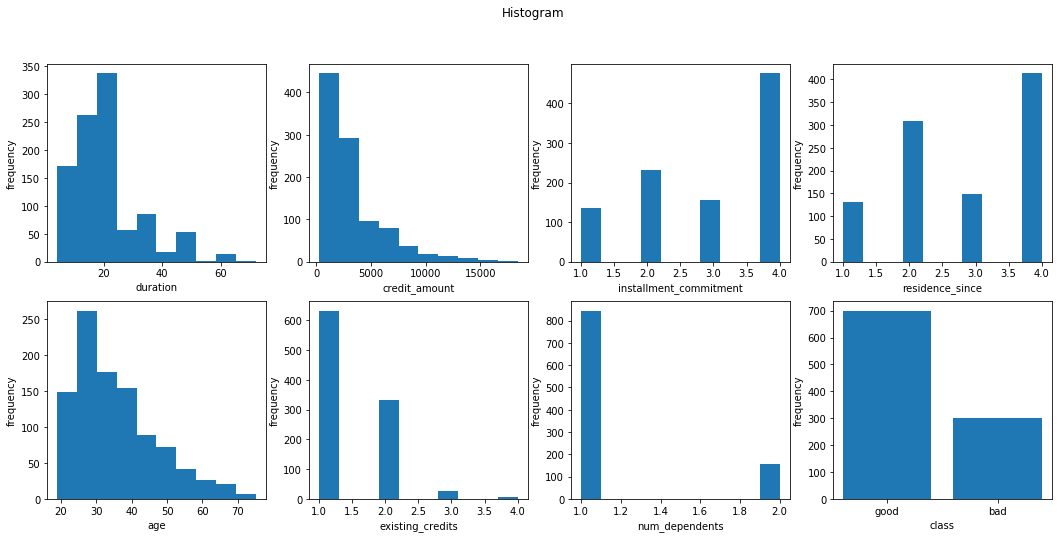

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(18,8))
plt.suptitle('Histogram')

axes[0,0].hist(data1.duration)
axes[0,0].set_xlabel('duration')
axes[0,0].set_ylabel('frequency')

axes[0,1].hist(data1.credit_amount)
axes[0,1].set_xlabel('credit_amount')
axes[0,1].set_ylabel('frequency')

axes[0,2].hist(data1.installment_commitment)
axes[0,2].set_xlabel('installment_commitment')
axes[0,2].set_ylabel('frequency')

axes[0,3].hist(data1.residence_since)
axes[0,3].set_xlabel('residence_since')
axes[0,3].set_ylabel('frequency')

axes[1,0].hist(data1.age)
axes[1,0].set_xlabel('age')
axes[1,0].set_ylabel('frequency')

axes[1,1].hist(data1.existing_credits)
axes[1,1].set_xlabel('existing_credits')
axes[1,1].set_ylabel('frequency')

axes[1,2].hist(data1.num_dependents)
axes[1,2].set_xlabel('num_dependents')
axes[1,2].set_ylabel('frequency')

axes[1,3].bar(target.value_counts().index,target.value_counts().values)
axes[1,3].set_xlabel('class')
axes[1,3].set_ylabel('frequency')

plt.show()

### 1.3 Split data into training and test set. Do not use the test set until a final evaluation in 1.5. Preprocess the data (such as treatment of categorical variables) without using a pipeline and evaluate an initial LogisticRegression model with an training/validation split.

In [8]:
df_logit = data1.copy()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df_logit, target, random_state=0)

In [10]:
ce = OneHotEncoder().fit(X_train)
X_train_encoded = ce.transform(X_train).toarray()

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_encoded, y_train, random_state=0)

In [12]:
# model evaluation
model_logit = LogisticRegression()
model_logit.fit(X_train, y_train)
print(f"Accuracy on the validation set: {model_logit.score(X_valid, y_valid)}")

Accuracy on the validation set: 0.7872340425531915


### 1.4 Use ColumnTransformer and pipeline to encode categorical variables (your choice of OneHotEncoder or another one from the categorical_encoder package, or both). Evaluate Logistic Regression, linear support vector machines and nearest neighbors using cross-validation. How different are the results? How does scaling the continuous features with StandardScaler influence the results?

In [13]:
df1 = data1.copy()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df1, target, random_state=0)

In [15]:
def nonscale_model_evaluation(model):    
    categorical = X_train.dtypes == 'category'
    
    preprocess_nonscale = make_column_transformer(
    (OneHotEncoder(), categorical))
    
    model_pipe = make_pipeline(preprocess_nonscale, model)
    scores = cross_val_score(model_pipe, X_train, y_train)
    return np.mean(scores)
    

In [16]:
# Accuracy of models without scaling
print(f'Accuracy of Logistic Regression:{nonscale_model_evaluation(LogisticRegression())}')
print(f'Accuracy of Linear SVC:{nonscale_model_evaluation(LinearSVC())}')                                        
print(f'Accuracy of Nearest Neighbors:{nonscale_model_evaluation(KNeighborsClassifier(n_neighbors=1))}')

Accuracy of Logistic Regression:0.7493333333333333
Accuracy of Linear SVC:0.7533333333333332
Accuracy of Nearest Neighbors:0.692


In [17]:
def scale_model_evaluation(model):
    categorical = X_train.dtypes == 'category'
    
    preprocess_scale = make_column_transformer(
    (StandardScaler(),~categorical),
    (OneHotEncoder(), categorical))
    
    model_pipe = make_pipeline(preprocess_scale, model)
    scores = cross_val_score(model_pipe, X_train, y_train)
    return np.mean(scores)
    

In [18]:
# Accuracy of models without scaling
print(f'Accuracy of Logistic Regression:{scale_model_evaluation(LogisticRegression())}')
print(f'Accuracy of Linear SVC:{scale_model_evaluation(LinearSVC())}')                                        
print(f'Accuracy of Nearest Neighbors:{scale_model_evaluation(KNeighborsClassifier(n_neighbors=1))}')

Accuracy of Logistic Regression:0.7586666666666668
Accuracy of Linear SVC:0.7546666666666667
Accuracy of Nearest Neighbors:0.692


1. How different are the results

If we don't scale the data, LinearSVC has the best performance with accuracy at around 75.3%; If we scale the data, Logistic Regreession performs best with accuracy at 75.9%. Nearest Neighbor has the lowest accuracy no matter we scale or not.

2. How does scaling the continuous features with StandardScaler influence the results?

For Logistic Regression and LinearSVC models, scaling would help improve the accuracy, and Logistic Regression model has a higher improvement.

For Nearest neighbors we do not see much change of model performance, but considering scaling would make more sense for distance-based model, we decide to use scaled data for further parameter tuning this model.

### 1.5 Tune the parameters using GridSearchCV. Do the results improve? Evaluate only the be model on the test set. Visualize the performance as function of the parameters for all three models.

In [19]:
# build function for parameter tuning
def model_gridsearch(model,param_grid):
    categorical = X_train.dtypes == 'category'
    
    preprocess_scale = make_column_transformer(
    (StandardScaler(),~categorical),
    (OneHotEncoder(), categorical))
    
    model_pipe = make_pipeline(preprocess_scale, model)
    grid = GridSearchCV(model_pipe, param_grid,return_train_score=True)
    grid.fit(X_train, y_train)
    return grid.best_params_,grid.best_score_

In [20]:
# tuning 'C' for Logistic Regression
print('Best parameter and best mean cross-validation score for Logistic Regression:')
model_gridsearch( 
    LogisticRegression(), 
    param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1,100,500,750,1000]})

Best parameter and best mean cross-validation score for Logistic Regression:


({'logisticregression__C': 750}, 0.7613333333333333)

In [21]:
# tuning 'C' for LinearSVC
print('Best parameter and best mean cross-validation score for LinearSVC:')
model_gridsearch( 
    LinearSVC(), 
    param_grid={'linearsvc__C': [0.01, 0.1, 1, 10, 100, 1000]})

Best parameter and best mean cross-validation score for LinearSVC:


({'linearsvc__C': 0.1}, 0.7653333333333333)

In [22]:
# tuning 'n_neighbors' for KNeighborsClassifier
print('Best parameter and best mean cross-validation score for KNeighborsClassifier:')
model_gridsearch( 
    KNeighborsClassifier(), 
    param_grid={'kneighborsclassifier__n_neighbors': np.arange(1,11)})

Best parameter and best mean cross-validation score for KNeighborsClassifier:


({'kneighborsclassifier__n_neighbors': 9}, 0.7466666666666666)

1. Do the results improve? 
    - All three model has an improved result after doing gridsearch

In [23]:
# evaluate model on the test set
def model_evaluation(model):
    categorical = X_train.dtypes == 'category'
    
    preprocess_scale = make_column_transformer(
    (StandardScaler(),~categorical),
    (OneHotEncoder(), categorical))
    
    model_pipe = make_pipeline(preprocess_scale, model)
    model_pipe.fit(X_train, y_train)
    return model_pipe.score(X_test, y_test)   

In [24]:
print(f'model performance of Logistic Regression on test set:{model_evaluation(LogisticRegression(C=750))}')
print(f'model performance of LinearSVC on test set:{model_evaluation(LinearSVC(C=0.1))}')
print(f'model performance of KNeighborsClassifier on test set:{model_evaluation(KNeighborsClassifier(n_neighbors=9))}')

model performance of Logistic Regression on test set:0.732
model performance of LinearSVC on test set:0.736
model performance of KNeighborsClassifier on test set:0.708


2. Evaluate only the be model on the test set
    - The best model according to gridsearch should be LinearSVC with C=0.1, the accuracy on the test set is 73.6%. We evaluate all the three models to double check the results.

In [25]:
# build function for model performance visualization
def performance(model,param_grid,label,title):
    categorical = X_train.dtypes == 'category'
    
    preprocess_scale = make_column_transformer(
    (StandardScaler(),~categorical),
    (OneHotEncoder(), categorical))
    
    model_pipe = make_pipeline(preprocess_scale, model)
    grid = GridSearchCV(model_pipe, param_grid,return_train_score=True)
    grid.fit(X_train, y_train)
    results = pd.DataFrame(grid.cv_results_)
    
    train_scores_mean = results["mean_train_score"]
    train_scores_std = results["std_train_score"]
    test_scores_mean = results["mean_test_score"]
    test_scores_std = results["std_test_score"]
    
    plt.figure()
    plt.title(title)
    plt.xlabel(label)
    plt.ylabel('Score')
    
    # plot train scores
    plt.semilogx([*param_grid.values()][0], train_scores_mean, label='Mean Train score',
             color='navy')
    # create a shaded area between [mean - std, mean + std]
    plt.gca().fill_between([*param_grid.values()][0],
                       train_scores_mean - train_scores_std,
                       train_scores_mean + train_scores_std,
                       alpha=0.2,
                       color='navy')
    plt.semilogx([*param_grid.values()][0], test_scores_mean,
             label='Mean Test score', color='darkorange')

    # create a shaded area between [mean - std, mean + std]
    plt.gca().fill_between([*param_grid.values()][0],
                       test_scores_mean - test_scores_std,
                       test_scores_mean + test_scores_std,
                       alpha=0.2,
                       color='darkorange')

    plt.legend(loc='best')
    plt.show()

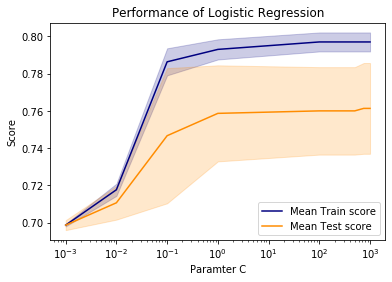

In [26]:
# visualize performance of Logistic Regression
performance(LogisticRegression(),param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1,100,500,750,1000]},label='Paramter C',title = 'Performance of Logistic Regression')

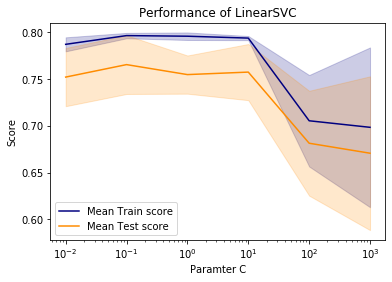

In [27]:
# visualize performance of LinearSVC
performance(LinearSVC(),
            param_grid={'linearsvc__C': [0.01, 0.1, 1, 10, 100, 1000]},
            label='Paramter C',title = 'Performance of LinearSVC')

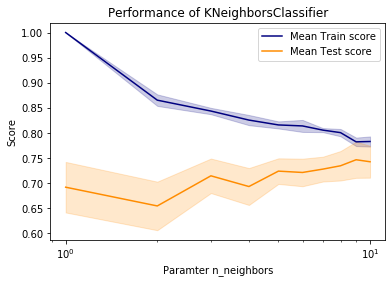

In [28]:
# visualize performance of KNeighborsClassifier
performance(KNeighborsClassifier(),
            param_grid={'kneighborsclassifier__n_neighbors': np.arange(1,11)},
            label='Paramter n_neighbors',title = 'Performance of KNeighborsClassifier')

### 1.6 Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the parameters that are found change? Do they change if you change the random seed of the shuffling? Or if you change the random state of the split into training and test data?

In [29]:
# create a gridsearch function with kfold strategy
def gridsearch_kfold(model,param_grid):
    
    categorical = X_train.dtypes == 'category'
    
    preprocess_scale = make_column_transformer(
    (StandardScaler(),~categorical),
    (OneHotEncoder(), categorical))
    
    kf = KFold(shuffle=True)
    
    model_pipe = make_pipeline(preprocess_scale, model)
    grid = GridSearchCV(model_pipe, param_grid,return_train_score=True,cv = kf)
    grid.fit(X_train, y_train)
    return grid.best_params_,grid.best_score_

In [30]:
# tuning 'C' for Logistic Regression
print('Best parameter and best mean cross-validation score for Logistic Regression by kfold strategy:')
gridsearch_kfold( 
    LogisticRegression(), 
    param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1,100,500,750,1000]})

Best parameter and best mean cross-validation score for Logistic Regression by kfold strategy:


({'logisticregression__C': 1}, 0.756)

In [31]:
# tuning 'C' for LinearSVC
print('Best parameter and best mean cross-validation score for LinearSVC by kfold strategy:')
gridsearch_kfold( 
    LinearSVC(), 
    param_grid={'linearsvc__C': [0.01, 0.1, 1, 10, 100, 1000]})

Best parameter and best mean cross-validation score for LinearSVC by kfold strategy:


({'linearsvc__C': 0.01}, 0.7586666666666667)

In [32]:
# tuning 'n_neighbors' for KNeighborsClassifier
print('Best parameter and best mean cross-validation score for KNeighborsClassifier by kfold strategy:')
gridsearch_kfold( 
    KNeighborsClassifier(), 
    param_grid={'kneighborsclassifier__n_neighbors': np.arange(1,11)})

Best parameter and best mean cross-validation score for KNeighborsClassifier by kfold strategy:


({'kneighborsclassifier__n_neighbors': 7}, 0.7413333333333333)

1. Do the parameters that are found change?
    - The parameters found do change by change cross validation strategy from stratified kfold to kfold.

In [33]:
# change the random seed of shuffling
def gridsearch_kfold_random_shuffle(model,param_grid):
    
    categorical = X_train.dtypes == 'category'
    
    preprocess_scale = make_column_transformer(
    (StandardScaler(),~categorical),
    (OneHotEncoder(), categorical))

    for i in range(10):    
        kf = KFold(shuffle=True,random_state = i)

        model_pipe = make_pipeline(preprocess_scale, model)
        grid = GridSearchCV(model_pipe, param_grid,return_train_score=True,cv = kf)
        grid.fit(X_train, y_train)
        print(f'random state {i}: {grid.best_params_,grid.best_score_}')

In [34]:
# tuning 'C' for Logistic Regression with different random state
gridsearch_kfold_random_shuffle( 
    LogisticRegression(), 
    param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1,100,500,750,1000]})

random state 0: ({'logisticregression__C': 0.1}, 0.748)
random state 1: ({'logisticregression__C': 1}, 0.752)
random state 2: ({'logisticregression__C': 0.1}, 0.756)
random state 3: ({'logisticregression__C': 1}, 0.7573333333333334)
random state 4: ({'logisticregression__C': 0.1}, 0.76)
random state 5: ({'logisticregression__C': 0.1}, 0.756)
random state 6: ({'logisticregression__C': 1}, 0.76)
random state 7: ({'logisticregression__C': 1}, 0.752)
random state 8: ({'logisticregression__C': 0.1}, 0.7493333333333333)
random state 9: ({'logisticregression__C': 1}, 0.7573333333333333)


In [35]:
# tuning 'C' for LinearSVC with different random state
gridsearch_kfold_random_shuffle( 
    LinearSVC(), 
    param_grid={'linearsvc__C': [0.01, 0.1, 1, 10, 100, 1000]})

random state 0: ({'linearsvc__C': 0.1}, 0.7533333333333333)
random state 1: ({'linearsvc__C': 1}, 0.7493333333333333)
random state 2: ({'linearsvc__C': 1}, 0.756)
random state 3: ({'linearsvc__C': 0.1}, 0.756)
random state 4: ({'linearsvc__C': 0.01}, 0.764)
random state 5: ({'linearsvc__C': 0.1}, 0.7586666666666668)
random state 6: ({'linearsvc__C': 0.1}, 0.7586666666666667)
random state 7: ({'linearsvc__C': 0.1}, 0.7506666666666667)
random state 8: ({'linearsvc__C': 0.1}, 0.7506666666666666)
random state 9: ({'linearsvc__C': 0.1}, 0.764)


In [36]:
# tuning n_neighbors for KNeighborsClassifier
gridsearch_kfold_random_shuffle( 
    KNeighborsClassifier(), 
    param_grid={'kneighborsclassifier__n_neighbors': np.arange(1,11)})

random state 0: ({'kneighborsclassifier__n_neighbors': 9}, 0.7453333333333335)
random state 1: ({'kneighborsclassifier__n_neighbors': 9}, 0.7386666666666667)
random state 2: ({'kneighborsclassifier__n_neighbors': 9}, 0.7386666666666667)
random state 3: ({'kneighborsclassifier__n_neighbors': 5}, 0.7453333333333333)
random state 4: ({'kneighborsclassifier__n_neighbors': 7}, 0.728)
random state 5: ({'kneighborsclassifier__n_neighbors': 7}, 0.7453333333333333)
random state 6: ({'kneighborsclassifier__n_neighbors': 5}, 0.7253333333333334)
random state 7: ({'kneighborsclassifier__n_neighbors': 5}, 0.7266666666666668)
random state 8: ({'kneighborsclassifier__n_neighbors': 5}, 0.7333333333333334)
random state 9: ({'kneighborsclassifier__n_neighbors': 9}, 0.7386666666666667)


2. Do they change if you change the random seed of the shuffling?
    - The parameters change by using different random states for all three models. Then we set random state constant(the one has the best score in gridsearch), and see how changing random split would affect the parameters. 

In [37]:
# change random state of train_test_split
def gridsearch_kfold_random_splitting(model,param_grid,rs):
    for i in range(10): 
        X_train, X_test, y_train, y_test = train_test_split(
        df1, target, random_state=i)

        categorical = X_train.dtypes == 'category'

        preprocess_scale = make_column_transformer(
        (StandardScaler(),~categorical),
        (OneHotEncoder(), categorical))

        kf = KFold(shuffle=True,random_state = rs)

        model_pipe = make_pipeline(preprocess_scale, model)
        grid = GridSearchCV(model_pipe, param_grid,return_train_score=True,cv = kf)
        grid.fit(X_train, y_train)
        print(f'random split {i}: {grid.best_params_,grid.best_score_}')

In [38]:
# tuning 'C' for Logistic Regression with different split
gridsearch_kfold_random_splitting( 
    LogisticRegression(), 
    param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1,100,500,750,1000]}, 
    rs=4)

random split 0: ({'logisticregression__C': 0.1}, 0.76)
random split 1: ({'logisticregression__C': 0.1}, 0.7573333333333333)
random split 2: ({'logisticregression__C': 0.1}, 0.7706666666666667)
random split 3: ({'logisticregression__C': 1000}, 0.7546666666666667)
random split 4: ({'logisticregression__C': 0.1}, 0.7586666666666666)
random split 5: ({'logisticregression__C': 0.1}, 0.7573333333333334)
random split 6: ({'logisticregression__C': 0.1}, 0.7613333333333333)
random split 7: ({'logisticregression__C': 1}, 0.7373333333333334)
random split 8: ({'logisticregression__C': 0.1}, 0.752)
random split 9: ({'logisticregression__C': 0.1}, 0.7533333333333333)


In [39]:
# tuning 'C' for LinearSVC with different split
gridsearch_kfold_random_splitting( 
    LinearSVC(), 
    param_grid={'linearsvc__C': [0.01, 0.1, 1, 10, 100, 1000]},
    rs=4)

random split 0: ({'linearsvc__C': 0.01}, 0.764)
random split 1: ({'linearsvc__C': 0.01}, 0.7546666666666666)
random split 2: ({'linearsvc__C': 0.01}, 0.768)
random split 3: ({'linearsvc__C': 0.1}, 0.752)
random split 4: ({'linearsvc__C': 10}, 0.76)
random split 5: ({'linearsvc__C': 0.01}, 0.756)
random split 6: ({'linearsvc__C': 0.1}, 0.7613333333333333)
random split 7: ({'linearsvc__C': 10}, 0.7373333333333333)
random split 8: ({'linearsvc__C': 0.01}, 0.7466666666666667)
random split 9: ({'linearsvc__C': 0.01}, 0.7546666666666667)


In [41]:
# tuning 'n_neighbors' for KNeighborsClassifier
gridsearch_kfold_random_splitting( 
    KNeighborsClassifier(), 
    param_grid={'kneighborsclassifier__n_neighbors': np.arange(1,11)},
    rs=0)

random split 0: ({'kneighborsclassifier__n_neighbors': 9}, 0.7453333333333335)
random split 1: ({'kneighborsclassifier__n_neighbors': 10}, 0.74)
random split 2: ({'kneighborsclassifier__n_neighbors': 5}, 0.7493333333333333)
random split 3: ({'kneighborsclassifier__n_neighbors': 5}, 0.7546666666666666)
random split 4: ({'kneighborsclassifier__n_neighbors': 7}, 0.7333333333333334)
random split 5: ({'kneighborsclassifier__n_neighbors': 5}, 0.752)
random split 6: ({'kneighborsclassifier__n_neighbors': 5}, 0.7466666666666667)
random split 7: ({'kneighborsclassifier__n_neighbors': 9}, 0.7186666666666668)
random split 8: ({'kneighborsclassifier__n_neighbors': 5}, 0.74)
random split 9: ({'kneighborsclassifier__n_neighbors': 7}, 0.7306666666666667)


3. if you change the random state of the split into training and test data?
    - Given random seed of shuffling unchanged, parameters would change if we change use different random state of splitting. 

### 1.7 Visualize the 20 most important coefficients for LogisticRegression and Linear Support Vector Machines using hyper-parameters that performed well in the grid-search.

In [47]:
# build function for coefficient visualization
def coef_visual(model):
    X_train, X_test, y_train, y_test = train_test_split(
            df1, target, random_state=6)

    categorical = X_train.dtypes == 'category'

    preprocess_scale = make_column_transformer(
    (StandardScaler(),~categorical),
    (OneHotEncoder(), categorical))

    model_pipe = make_pipeline(preprocess_scale, model)
    model_pipe.fit(X_train, y_train)

    coef = model_pipe.steps[1][1].coef_
    return coef

In [53]:
coef_lr = coef_visual(LogisticRegression(C=750))

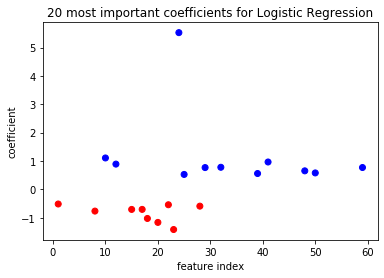

In [57]:
# visualize coefficients for Logistic Regression
coef = [(index, value) for (index, value) in enumerate(coef_lr[0])]
coef = sorted(coef, key = lambda x: abs(x[1]), reverse = True)[:20]
x = [c[0] for c in coef]
y = [c[1] for c in coef]
plt.scatter(x, y, c=np.sign(y), cmap="bwr_r")
plt.title('20 most important coefficients for Logistic Regression')
plt.xlabel('feature index')
plt.ylabel('coefficient')
plt.show()

In [58]:
coef_svc = coef_visual(LinearSVC(C=0.01))

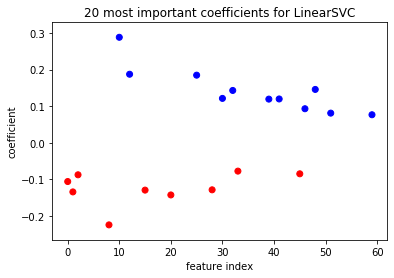

In [59]:
# visualize coefficients for LinearSVC
coef = [(index, value) for (index, value) in enumerate(coef_svc[0])]
coef = sorted(coef, key = lambda x: abs(x[1]), reverse = True)[:20]
x = [c[0] for c in coef]
y = [c[1] for c in coef]
plt.scatter(x, y, c=np.sign(y), cmap="bwr_r")
plt.title('20 most important coefficients for LinearSVC')
plt.xlabel('feature index')
plt.ylabel('coefficient')
plt.show()